In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

/home/vicky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [3]:
legend_elements = [Line2D([0], [0], color='b', lw=2, label='Car'),
                   Line2D([0], [0], color='orange', lw=2, label='Bike')]

In [4]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [5]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [6]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
#     df1['AX1'] = gaussian_filter(df['AX1'], window_length)
#     df1['AY1'] = gaussian_filter(df['AY1'], window_length)
#     df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

#     df1['GX1'] = gaussian_filter(df['GX1'], window_length)
#     df1['GY1'] = gaussian_filter(df['GY1'], window_length)
#     df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    
#     df1['orientX'] = gaussian_filter(df['orientX'], window_length)
#     df1['orientY'] = gaussian_filter(df['orientY'], window_length)
#     df1['orientZ'] = gaussian_filter(df['orientZ'], window_length)

    return df1

In [7]:
def Amplitude(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]]**2 + df[input_features[1]]**2  + df[input_features[2]]**2)**(1/2)
  
    

In [8]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw

In [9]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['orientZ'] / 2. * np.pi / 180
        roll  = df['orientX'] / 2. * np.pi / 180
        pitch = df['orientY'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [10]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [11]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [12]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        

In [13]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [14]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT1(x):
    reals = np.real(np.fft.rfft(x))
    imagn = np.imag(np.fft.rfft(x))

    complexs = [reals[0]]
    n = len(reals)
    if(n%2 == 0):
        complexs.append(imagn[0])
    for j in range(1, n-1):
        complexs.append(reals[j])
        complexs.append(imagn[j])
    if( len(x) > len(complexs)):
        complexs.append(reals[j])
    if( len(x) > len(complexs)):
        complexs.append(imagn[j])
    return complexs


In [15]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gx = df['GX1'].values[i: i + N_TIME_STEPS]
        gy = df['GY1'].values[i: i + N_TIME_STEPS]
        gz = df['GZ1'].values[i: i + N_TIME_STEPS]
        
        ax = df['AX1'].values[i: i + N_TIME_STEPS]
        ay = df['AY1'].values[i: i + N_TIME_STEPS]
        az = df['AZ1'].values[i: i + N_TIME_STEPS]
        
        #Frequency domain feature generation from time series accelerometer data
        input_features = ['AX1', 'AY1', 'AZ1']
        output_feature = ['fAX', 'fAY', 'fAZ']

        
        fax = df['fAX'].values[i: i + N_TIME_STEPS]
        fay = df['fAY'].values[i: i + N_TIME_STEPS]
        faz = df['fAZ'].values[i: i + N_TIME_STEPS]
        
        ma = df['mAcc'].values[i: i + N_TIME_STEPS]
        mz = df['mGyro'].values[i: i + N_TIME_STEPS]
#         ox = df[''].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([gx, gy, gz, ax, ay, az, ma, mz, fax, fay, faz])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [16]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [17]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
#         print(i , '=>', dist)
        loss.append(dist)
    
    return loss

In [18]:
def data_preprocessing(df):
    #apply gaussian filter with window size 10
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    Amplitude(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    Amplitude(df, input_features, output_feature)
    
    #Re-Orientation of 3-axis acc. and gyro sensor data
    Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    rotate(df)
    

 
    
    return df

In [19]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [20]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)
    df = data_preprocessing(df)
    
    return df
    

In [21]:
 
path_acc = os.getcwd() + '/data/bike_test/*/Accelerometer.csv'
path_gyro= os.getcwd() + '/data/bike_test/*/Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)

bike_df = []
bike_df = pd.Series(bike_df)
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[1500 : n-500]
    print("len of this file ",df_this.shape)
    bike_df = pd.concat([bike_df, df_this])
    print(bike_df.shape)
bike_df.reset_index(drop = True, inplace = True)
bike_df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/bike_test/2018-08-23_16-18-07/Accelerometer.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike_test/2018-08-23_16-18-07/Gyroscope.csv
len of this file  (14390, 28)
len of this file  (12390, 28)
(12390, 29)


/home/vicky/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


,0,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,...,quaternionW,quaternionX,quaternionY,quaternionZ,AX1,AY1,AZ1,GX1,GY1,GZ1
0,NaN,-0.485601,-1.330190,-10.071047,-0.021838,-0.032621,0.018980,bike,56.461505,187.755993,...,0.921126,0.047107,0.051498,-0.382957,-1.877604,0.677345,-9.972312,-0.037373,-0.010003,0.020111
1,NaN,-0.487046,-1.332939,-10.061229,-0.019643,-0.032876,0.013955,bike,13.075333,30.348545,...,0.921109,0.047268,0.051645,-0.382959,-1.881466,0.679308,-9.961972,-0.036309,-0.011092,0.014836
2,NaN,-0.488958,-1.336838,-10.050813,-0.017303,-0.033026,0.009186,bike,-35.093096,13.412890,...,0.921086,0.047474,0.051838,-0.382962,-1.886946,0.681905,-9.950854,-0.035054,-0.012236,0.009799
3,NaN,-0.491437,-1.342024,-10.039911,-0.014879,-0.033096,0.004681,bike,8.597420,-94.712528,...,0.921058,0.047732,0.052082,-0.382965,-1.894235,0.685274,-9.939045,-0.033668,-0.013413,0.005016
4,NaN,-0.494546,-1.348595,-10.028685,-0.012418,-0.033107,0.000446,bike,-63.037960,-45.554812,...,0.921023,0.048045,0.052379,-0.382969,-1.903470,0.689498,-9.926692,-0.032202,-0.014603,0.000494


In [22]:
#latex table generate
table_df = bike_df[['AX','AY','AZ', 'GX', 'GY','GZ']].head(10)
#print(table_df.to_latex())
latex_file = open("table.tex", "w")
latex_file.write(table_df.to_latex())
latex_file.close()

In [23]:
#latex table generate
table_df = bike_df[['AX','AY','AZ', 'GX', 'GY','GZ','mAcc','mGyro','fAX','fAY','fAZ']].head(10)
#print(table_df.to_latex())
latex_file = open("table_with_all_features.tex", "w")
latex_file.write(table_df.to_latex())
latex_file.close()

In [24]:
print(bike_df.shape)
bike_df.columns

(12390, 29)


Index([            0,          'AX',          'AY',          'AZ',
                'GX',          'GY',          'GZ',    'activity',
               'fAX',         'fAY',         'fAZ',         'fGX',
               'fGY',         'fGZ',        'mAcc',       'mGyro',
           'orientX',     'orientY',     'orientZ', 'quaternionW',
       'quaternionX', 'quaternionY', 'quaternionZ',         'AX1',
               'AY1',         'AZ1',         'GX1',         'GY1',
               'GZ1'],
      dtype='object')

In [25]:
bike_df = bike_df[2500:3500]
bike_df.reset_index(drop = True, inplace = True)

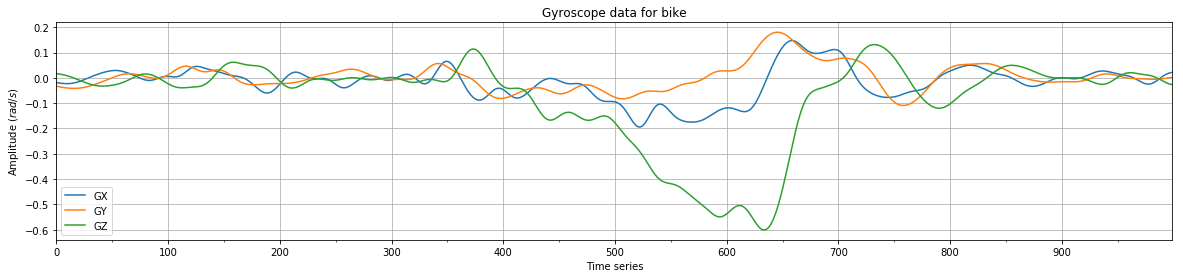

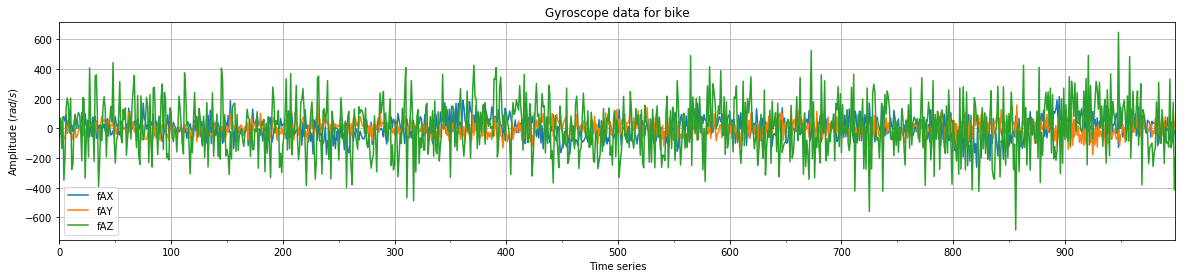

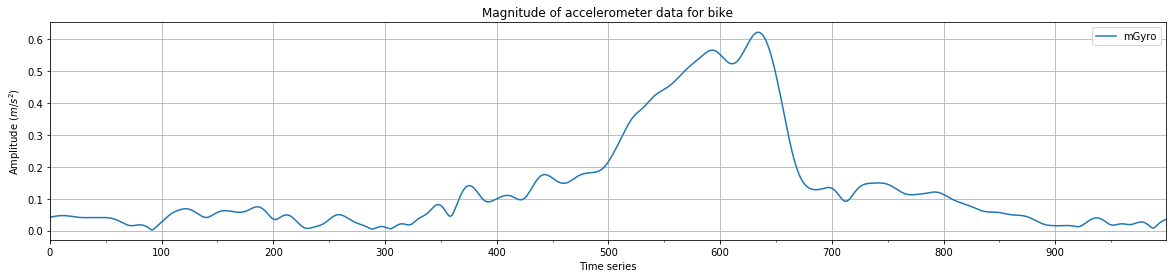

In [26]:
fig, ax = plt.subplots()

bike_df.reset_index(drop = True, inplace = True)
bike_df[['GX', 'GY', 'GZ']].plot(figsize = (20,4),ax=ax, title = "Gyroscope data for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, 1000, 100)
minor_ticks = np.arange(0, 1000, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('gyro_bike.png') 

plt.grid(True)


fig, ax = plt.subplots()

bike_df.reset_index(drop = True, inplace = True)
bike_df[['fAX', 'fAY', 'fAZ']].plot(figsize = (20,4),ax=ax, title = "Gyroscope data for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, 1000, 100)
minor_ticks = np.arange(0, 1000, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('gyro_bike.png') 

plt.grid(True)

fig, ax = plt.subplots()

bike_df.reset_index(drop = True, inplace = True)
bike_df[['mGyro']].plot(figsize = (20,4),ax=ax, title = "Magnitude of accelerometer data for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($m/s^2$)')
major_ticks = np.arange(0, 1000, 100)
minor_ticks = np.arange(0, 1000, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('acc_bike.png') 

plt.grid(True)

In [25]:
bike_segments, bike_labels = segmentation(bike_df, 400)
np.array(bike_segments).shape

(32, 11, 400)

In [26]:
def DTWdistance(segments, ref):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = ref
        print("calculating dtw for feature ", i, "....")
        diff = loss_for_segments(y, x, i)
        print("Done")
        DTW_list.append(diff)
    
    return DTW_list  

In [27]:
ref  = [0.0]*400
len(ref)

400

In [29]:
bike_dtw_data = DTWdistance(bike_segments, ref)

calculating dtw for feature  0 ....
Done
calculating dtw for feature  1 ....
Done
calculating dtw for feature  2 ....
Done
calculating dtw for feature  3 ....
Done
calculating dtw for feature  4 ....
Done
calculating dtw for feature  5 ....
Done
calculating dtw for feature  6 ....
Done
calculating dtw for feature  7 ....
Done
calculating dtw for feature  8 ....
Done
calculating dtw for feature  9 ....
Done
calculating dtw for feature  10 ....
Done


In [30]:
print(np.array(bike_dtw_data).shape)
bike_dtw_data = [*zip(*bike_dtw_data)]
print(np.array(bike_dtw_data).shape)

(11, 32)
(32, 11)


In [31]:
import csv
with open("dtw_data_bike.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(bike_dtw_data)

In [27]:
path_acc = os.getcwd() + '/data/car/*/AccelerometerLinear.csv'
path_gyro= os.getcwd() + '/data/car/*/Gyroscope.csv' 

acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
car_df= []
car_df = pd.Series(car_df)
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[700 : n-700]
    print("len of this file ",df_this.shape)
    car_df = pd.concat([car_df, df_this])
    print(car_df.shape)
car_df.reset_index(drop = True, inplace = True)
car_df.head()

/home/vicky/Desktop/Dhananjay/human-activity/data/car/2018-08-17_16-50-00/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car/2018-08-17_16-50-00/Gyroscope.csv
len of this file  (13421, 28)
len of this file  (12021, 28)
(12021, 29)


/home/vicky/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


,0,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,...,quaternionW,quaternionX,quaternionY,quaternionZ,AX1,AY1,AZ1,GX1,GY1,GZ1
0,NaN,0.284398,-0.113304,0.205706,-0.007379,0.003521,-0.006469,car,100.670267,9.252116,...,0.873322,-0.339327,-0.325610,0.127062,0.080290,0.147306,0.328465,-0.001342,-0.003970,-0.009546
1,NaN,0.281660,-0.107433,0.207359,-0.007154,0.001670,-0.006229,car,-92.571854,-11.549625,...,0.874647,-0.341848,-0.315913,0.135394,0.083568,0.155421,0.320519,-0.001480,-0.005213,-0.007962
2,NaN,0.278261,-0.102627,0.207617,-0.007092,-0.000012,-0.005985,car,-33.980225,71.265285,...,0.875584,-0.343551,-0.308642,0.141650,0.085352,0.160503,0.313082,-0.001639,-0.006349,-0.006566
3,NaN,0.274396,-0.098903,0.206649,-0.007183,-0.001489,-0.005738,car,71.313204,-29.845868,...,0.876204,-0.344551,-0.303745,0.145911,0.085894,0.162843,0.306404,-0.001851,-0.007368,-0.005387
4,NaN,0.270100,-0.096242,0.205010,-0.007441,-0.002713,-0.005490,car,-42.659698,-6.336853,...,0.876707,-0.344517,-0.300880,0.148879,0.085207,0.162851,0.300774,-0.002159,-0.008259,-0.004473


In [28]:
print(car_df.shape)
car_df.columns

(12021, 29)


Index([            0,          'AX',          'AY',          'AZ',
                'GX',          'GY',          'GZ',    'activity',
               'fAX',         'fAY',         'fAZ',         'fGX',
               'fGY',         'fGZ',        'mAcc',       'mGyro',
           'orientX',     'orientY',     'orientZ', 'quaternionW',
       'quaternionX', 'quaternionY', 'quaternionZ',         'AX1',
               'AY1',         'AZ1',         'GX1',         'GY1',
               'GZ1'],
      dtype='object')

In [29]:
car_df = car_df[3400:4400]
car_df.reset_index(drop = True, inplace = True)

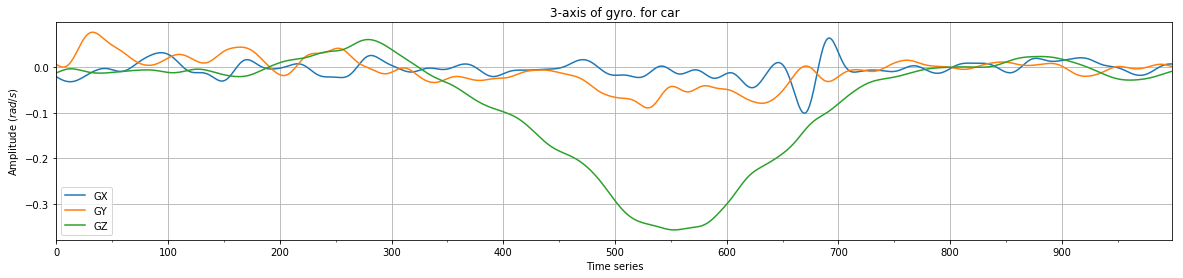

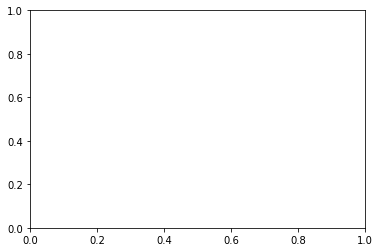

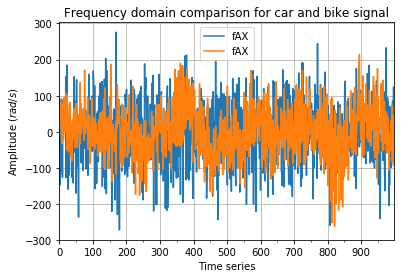

In [33]:
fig, ax = plt.subplots()
car_df[['GX','GY','GZ']].plot(figsize = (20,4),ax=ax, title = "3-axis of gyro. for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, 1000, 100)
minor_ticks = np.arange(0, 1000, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('gyro_car.png') 

plt.grid(True)

fig, ax = plt.subplots()

bike_df.reset_index(drop = True, inplace = True)
ax = car_df[['fAX']].plot(title = "Frequency domain comparison for car and bike signal")
bike_df[['fAX']].plot(ax=ax)

plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, 1000, 100)
minor_ticks = np.arange(0, 1000, 50)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

# fig, ax = plt.subplots()

# bike_df.reset_index(drop = True, inplace = True)
# bike_df[['orientX']].plot(figsize = (20,4),ax=ax, title = "X-axis(Roll) rotation for bike")
# plt.xlabel('Time series')
# plt.ylabel('Angle(degree))')
# major_ticks = np.arange(0, 2000, 100)
# minor_ticks = np.arange(0, 2000, 50)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# fig.savefig('abc.png') 

# plt.grid(True)


# fig, ax = plt.subplots()

# car_df.reset_index(drop = True, inplace = True)
# car_df[['orientX']].plot(figsize = (20,4),ax=ax, title = "X-axis(Roll) rotation for car")
# plt.xlabel('Time series')
# plt.ylabel('Angle(degree))')
# major_ticks = np.arange(0, 2000, 100)
# minor_ticks = np.arange(0, 2000, 50)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# fig.savefig('abc.png') 

# plt.grid(True)

# fig, ax = plt.subplots()

# bike_df.reset_index(drop = True, inplace = True)
# bike_df[['orientZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis(Yaw) rotation for bike")
# plt.xlabel('Time series')
# plt.ylabel('Angle(degree))')
# major_ticks = np.arange(0, 2000, 100)
# minor_ticks = np.arange(0, 2000, 50)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# fig.savefig('abc.png') 

# plt.grid(True)


# fig, ax = plt.subplots()

# car_df.reset_index(drop = True, inplace = True)
# car_df[['orientZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis(Yaw) rotation for car")
# plt.xlabel('Time series')
# plt.ylabel('Angle(degree))')
# major_ticks = np.arange(0, 2000, 100)
# minor_ticks = np.arange(0, 2000, 50)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# fig.savefig('abc.png') 

# plt.grid(True)

In [96]:
car_segments, car_labels = segmentation(car_df, 400)
np.array(car_segments).shape

(32, 11, 400)

In [97]:
car_dtw_data = DTWdistance(car_segments, ref)

NameError: name 'ref' is not defined

In [ ]:
print(np.array(car_dtw_data).shape)
car_dtw_data = [*zip(*car_dtw_data)]
print(np.array(car_dtw_data).shape)


In [156]:
import csv
with open("DTW_data_car.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(car_dtw_data)

In [157]:
car_dtw_data =  [*zip(*car_dtw_data)]
bike_dtw_data = [*zip(*bike_dtw_data)]

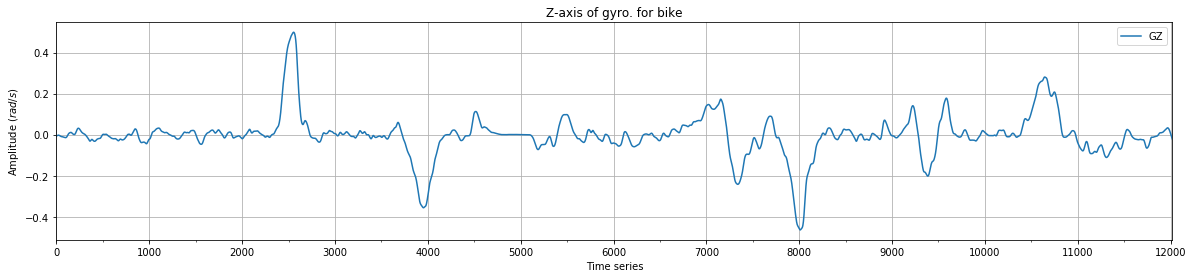

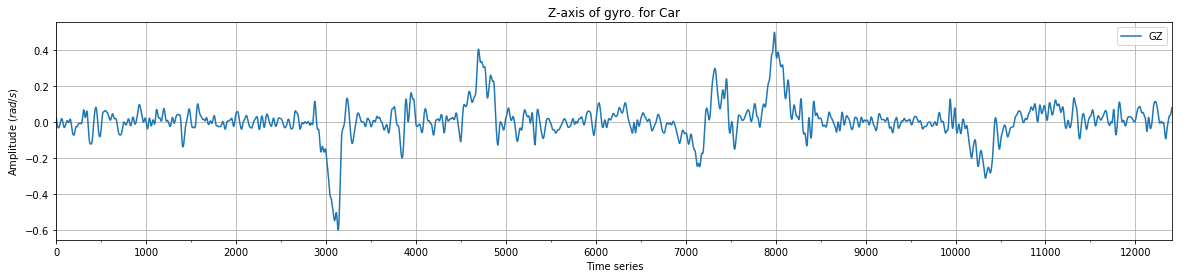

In [158]:
fig, ax = plt.subplots()
n = len(car_df)
car_df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 1000)
minor_ticks = np.arange(0, n, 500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

fig, ax = plt.subplots()
n = len(bike_df)
bike_df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for Car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 1000)
minor_ticks = np.arange(0, n, 500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

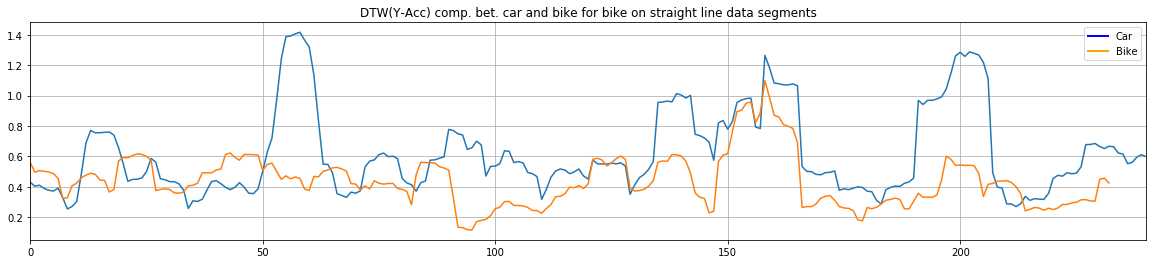

In [172]:


y1 = pd.Series(bike_dtw_data[0])
y2 = pd.Series(car_dtw_data[0])
# print(bike_dtw_data[0])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Y-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

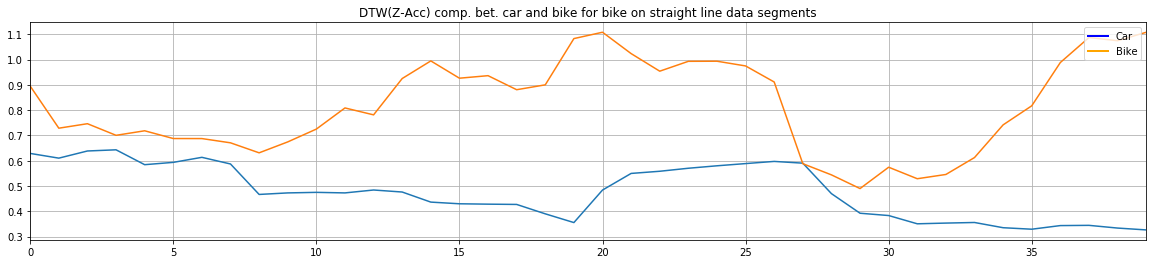

In [174]:
y1 = pd.Series(bike_dtw_data[1][0:40])
y2 = pd.Series(car_dtw_data[1][0:40])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Z-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

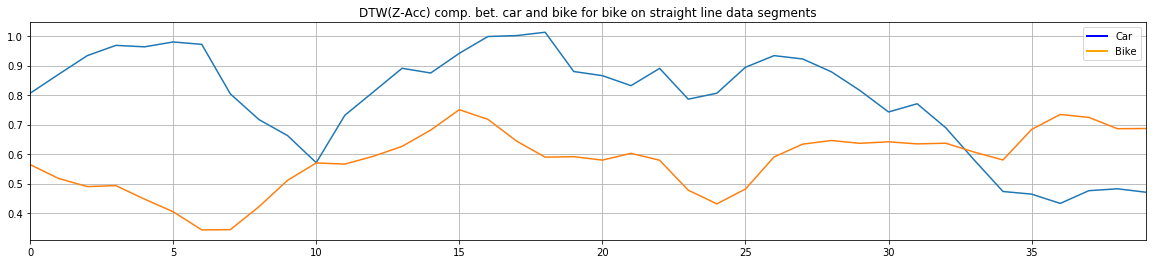

In [175]:
y1 = pd.Series(bike_dtw_data[2][0:40])
y2 = pd.Series(car_dtw_data[2][0:40])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Z-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

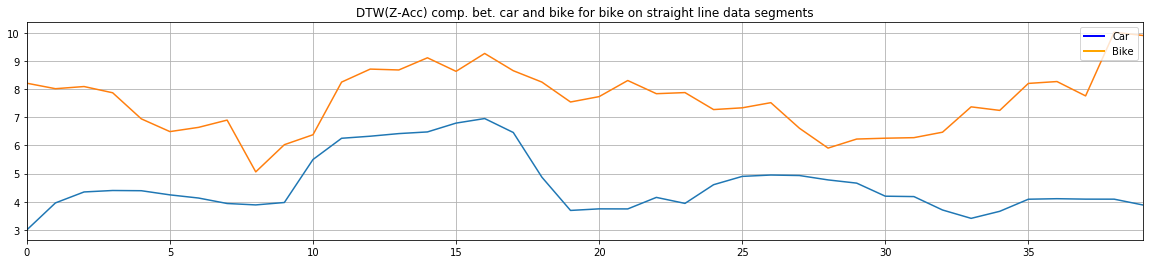

In [177]:
y1 = pd.Series(bike_dtw_data[4][0:40])
y2 = pd.Series(car_dtw_data[4][0:40])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Z-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

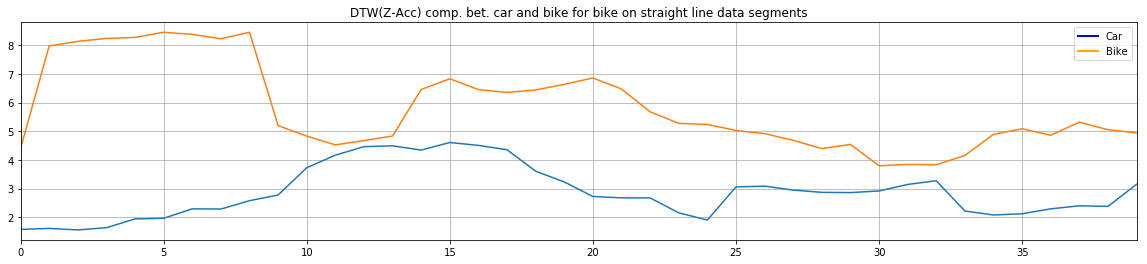

In [178]:
y1 = pd.Series(bike_dtw_data[5][0:40])
y2 = pd.Series(car_dtw_data[5][0:40])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Z-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

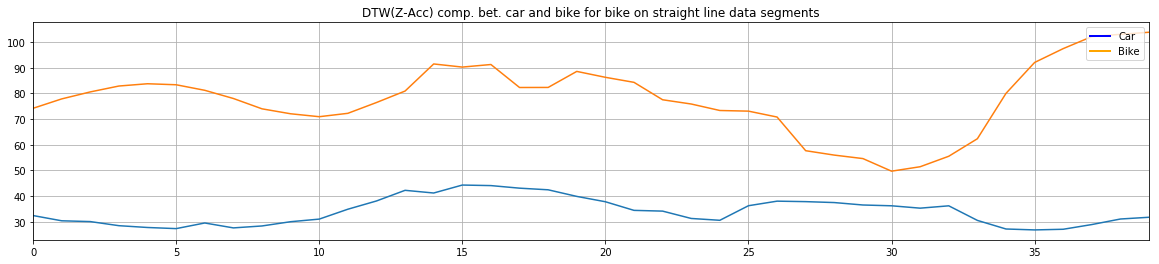

In [179]:
y1 = pd.Series(bike_dtw_data[6][0:40])
y2 = pd.Series(car_dtw_data[6][0:40])
y1.plot(figsize=(20,4), legend="Bike")
y2.plot(figsize=(20,4), legend="Car")
plt.legend(handles=legend_elements, loc='upper right')
plt.title("DTW(Z-Acc) comp. bet. car and bike for bike on straight line data segments")
plt.grid("True")

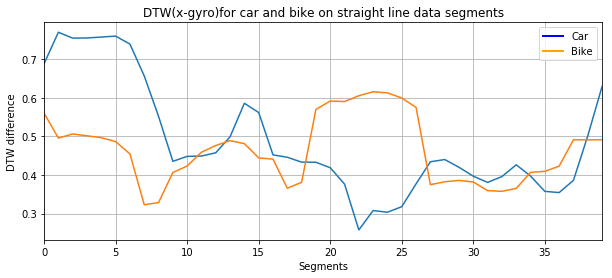

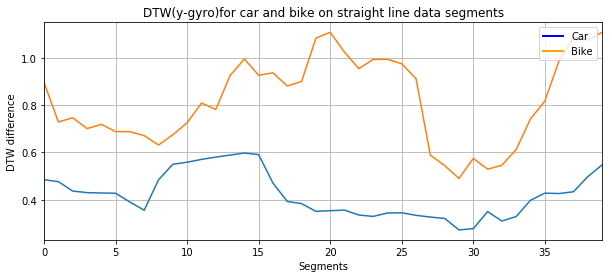

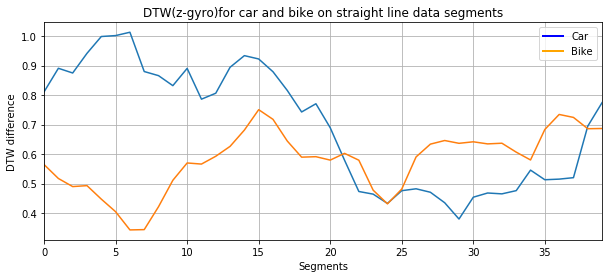

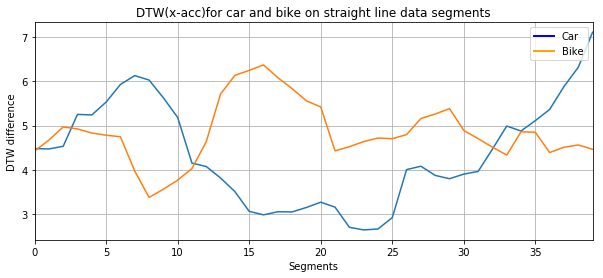

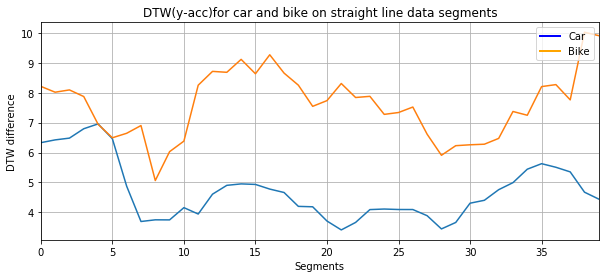

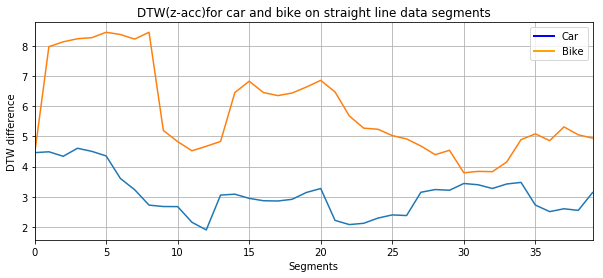

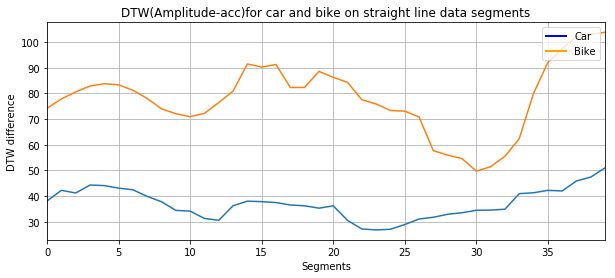

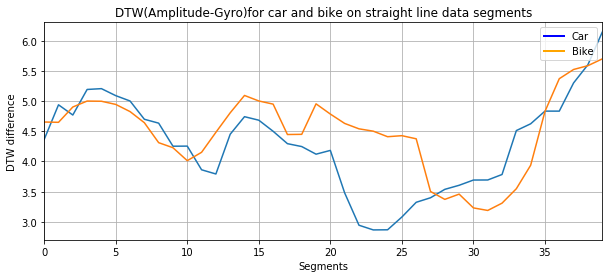

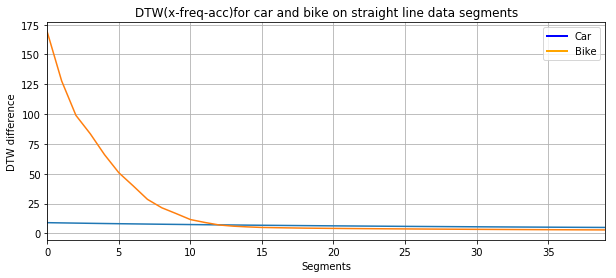

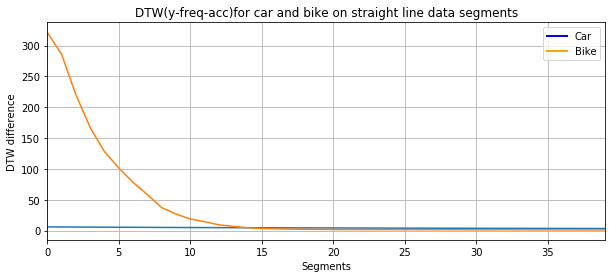

In [219]:
feature = { 0:'x-gyro', 1:'y-gyro', 2:'z-gyro',3:'x-acc',4:'y-acc',5:'z-acc',
           6:'Amplitude-acc',7:'Amplitude-Gyro',8:'x-freq-acc',9:'y-freq-acc',10:'z-freq-acc'}

for i in range(0,10):
    fig, ax = plt.subplots()
    y1 = pd.Series(bike_dtw_data[i][12:52])
    y2 = pd.Series(car_dtw_data[i][0:40])
    y1.plot(figsize=(10,4), legend="Bike")
    y2.plot(figsize=(10,4), legend="Car")
    plt.xlabel('Segments')
    plt.ylabel('DTW difference')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("DTW(" + feature[i] +")for car and bike on straight line data segments")
    plt.grid("True")

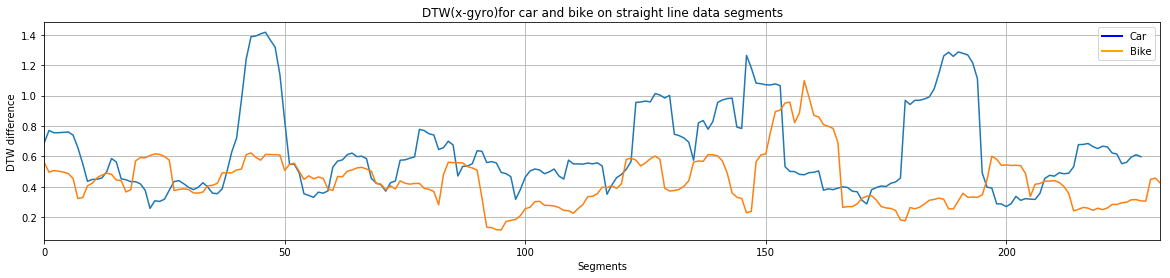

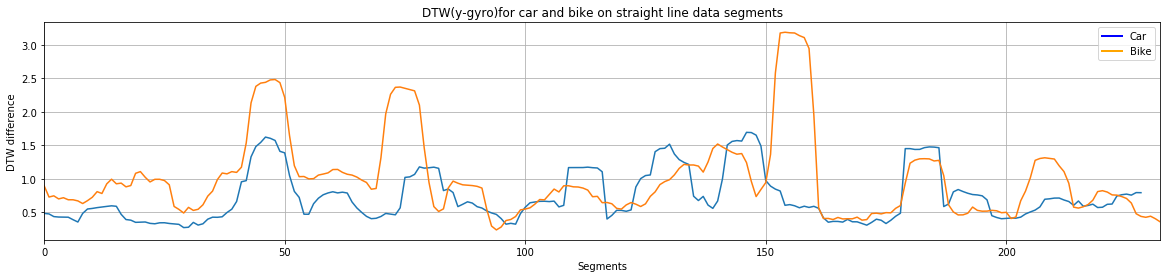

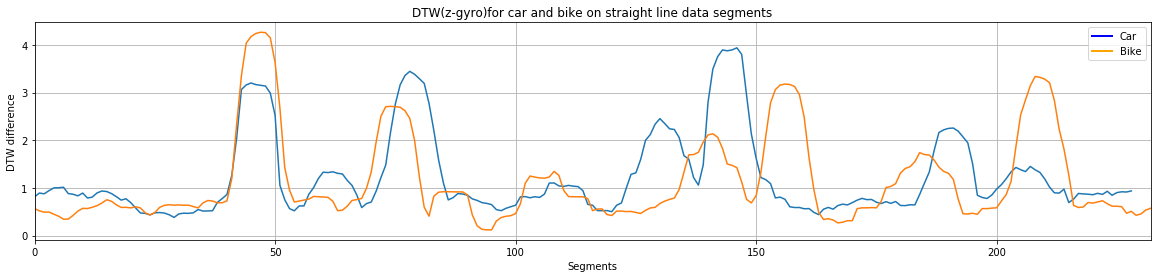

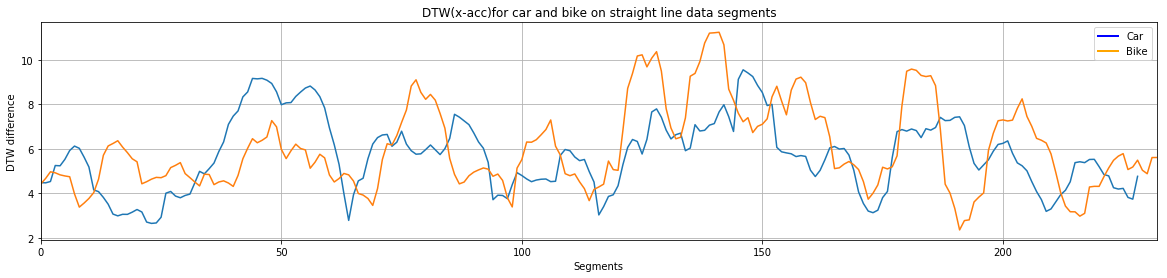

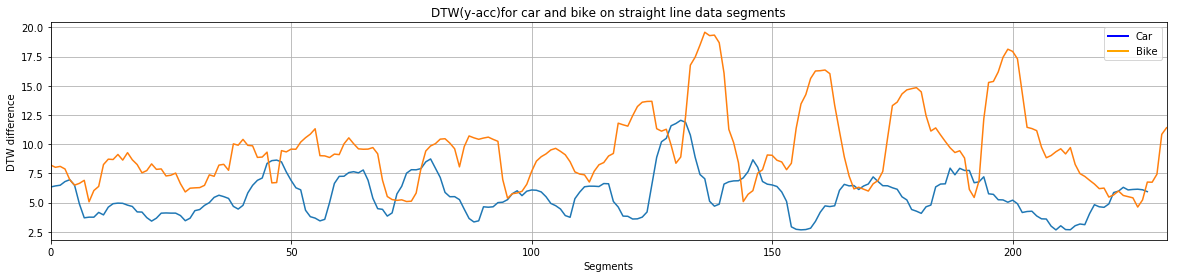

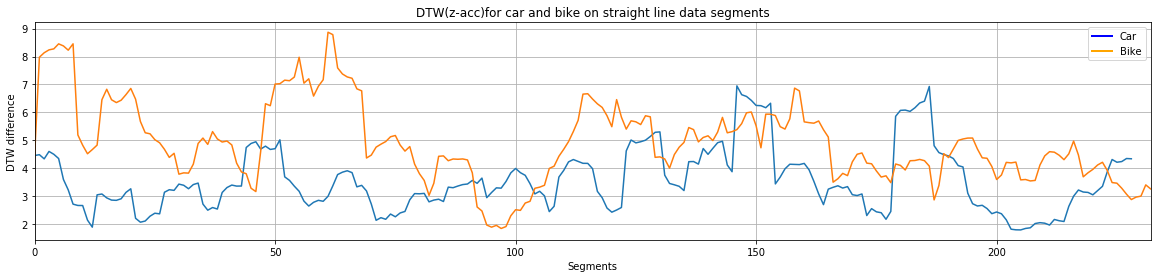

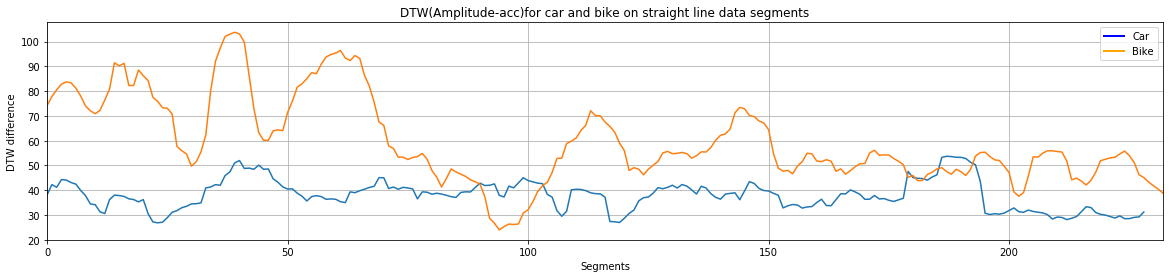

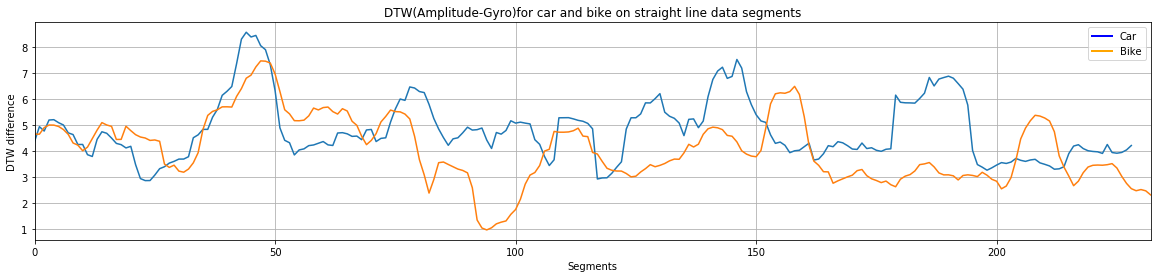

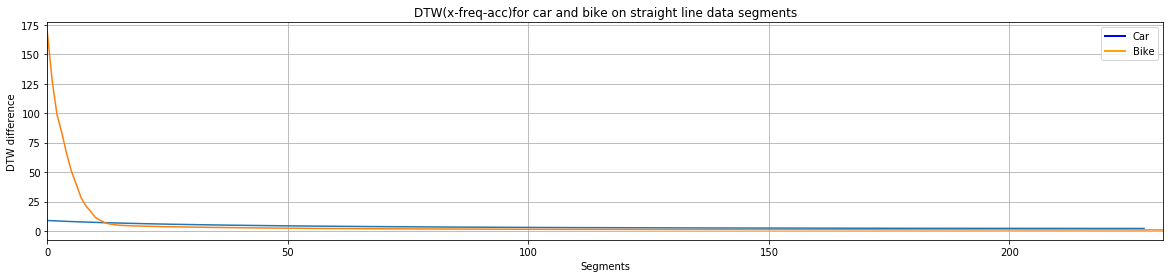

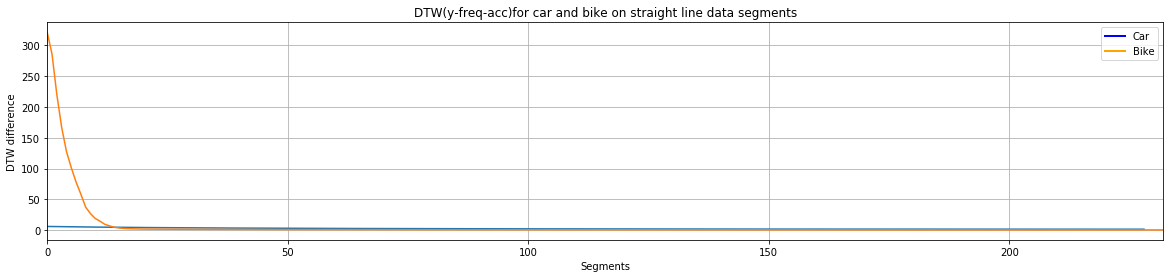

In [218]:
feature = { 0:'x-gyro', 1:'y-gyro', 2:'z-gyro',3:'x-acc',4:'y-acc',5:'z-acc',
           6:'Amplitude-acc',7:'Amplitude-Gyro',8:'x-freq-acc',9:'y-freq-acc',10:'z-freq-acc'}

for i in range(0,10):
    fig, ax = plt.subplots()
    y1 = pd.Series(bike_dtw_data[i][12:])
    y2 = pd.Series(car_dtw_data[i])
    y1.plot(figsize=(20,4), legend="Bike")
    y2.plot(figsize=(20,4), legend="Car")
    plt.xlabel('Segments')
    plt.ylabel('DTW difference')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("DTW(" + feature[i] +")for car and bike on straight line data segments")
    plt.grid("True")